In [1]:
import numpy as np
import pandas as pd
import neurokit2 as nk

In [2]:
cog_data_dir = "/home/ashish/Documents/github/VA/data/cognitive_data"
phy_data_dir = "/home/ashish/Documents/github/VA/data/physical_data"

- Currently, in Varun's data, there are 10 users with IDs from 0-9
- Each user has either one or two study sessions (session_1 and/or session_2)
- Each session contains multiple blocks of 0-back and 2-back tasks that the user performed.
    - Each block has three sets of data collected in different CSV files
        1. Score obtained (0-100) in the played session
            - Inside the block dir with ".csv" extension
        2. BiosignalPlux data (BSP) - ECG, GSR, Breathing, EMG, PulOxR, PulOxIR
            - Inside "block_x_x/bsp" dir with ".csv" extension
        3. EEG data
            - File inside "block_x_x/eeg" with no extension

## Collect all Cognitive Fatigue data into one Pandas DataFrame for all users

In [3]:
import os
from csv import reader

In [4]:
def get_n_back_score(block_dir):
    # return the final score (float from 0.0-1.0) of the N-back task that the user played (0-100)
    n_back_file = None
    for content in os.listdir(block_dir):
        if ".csv" in content:
            n_back_file = content
            break
    if not n_back_file:
        return 0
    
    with open(os.path.join(block_dir, n_back_file), "r") as file:
        csv_reader = reader(file)
        last_row = list(csv_reader)[-1]
        
    # Example row: ['3_Letter_C.png', '', '11', '0', '67', '1', '97.46835443037975', '0.0']
    # Second last column of the last row represents the final score in the game
    return round(float(last_row[-2]) / 100, 2)

In [19]:
def get_ecg_features(bsp_data):
    ecg_data = bsp_data['ECG'].values
    signals, info = nk.ecg_process(ecg_data, sampling_rate=1000)
    nk.ecg_plot(signals, sampling_rate=1000)
    # Select only four features from the signals (others seem to be zero for some reason)
    ecg_features = signals[["ECG_Raw", "ECG_Clean", "ECG_Rate", "ECG_Quality"]]
    return ecg_features

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality
0,27162.0,-3211.745288,83.478868,0.455119
1,27176.0,-3247.762401,83.478868,0.455119
2,27188.0,-3283.987059,83.478868,0.455119
3,27228.0,-3320.571805,83.478868,0.455119
4,27292.0,-3357.766675,83.478868,0.455119
...,...,...,...,...
172516,36478.0,41.543658,86.956522,0.471225
172517,36472.0,36.259619,86.956522,0.471225
172518,36464.0,28.992547,86.956522,0.471225
172519,36473.0,20.322783,86.956522,0.471225


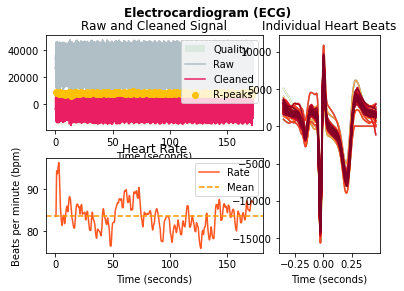

In [20]:
get_ecg_features(bsp_features)

In [6]:
def extract_eeg_features(block_dir):
    # Return as Pandas DF containing all relevant EEG features useful for the dataset
    eeg_dir = os.path.join(block_dir, "eeg")
    eeg_file_name = os.listdir(eeg_dir)[0]
    eeg_file_path = os.path.join(eeg_dir, eeg_file_name)
    eeg_data = pd.read_csv(eeg_file_path, delimiter=" ", names=["Type", "1", "2", "3", "4"])
    return eeg_data

In [7]:
def extract_bsp_features(block_dir):
    # Return as Pandas DF containing all relevant BSP (ECG, GSR, Breathing, EMG, PulOxR, PulOxlR)
    bsp_dir = os.path.join(block_dir, "bsp")
    bsp_file_name = os.listdir(bsp_dir)[0]
    bsp_file_path = os.path.join(bsp_dir, bsp_file_name)
    bsp_data = pd.read_csv(bsp_file_path)
    return bsp_data

In [8]:
session_counter = 0
for user_id in range(1, 10):
    user_dir = os.path.join(cog_data_dir, f"user_{user_id}")
    for session in os.listdir(user_dir):
        session_dir = os.path.join(user_dir, session)
        for block in os.listdir(session_dir):
            # Sanity check if the directory has the name "block" or not
            if "block" not in block or "practice" in block.lower():
                # Ignore directories other than block
                continue
            block_dir = os.path.join(session_dir, block)
            # For each block, we want to extract three different sets of data
            score = get_n_back_score(block_dir)
            print(f"{session_counter+1}. Score: {score} | Session: {session[-1]} | User_ID: {user_id}")
            session_counter += 1
            eeg_features = extract_eeg_features(block_dir)
            bsp_features = extract_bsp_features(block_dir)
            break
        break
    break

1. Score: 0.97 | Session: 1 | User_ID: 1


In [9]:
bsp_features

,Time,ECG,GSR,Breathing,EMG,PulOxR,PulOxIR
0,14:59:58.854092,27162.0,11219.0,59604.0,32789.0,0.0,0.0
1,14:59:58.854137,27176.0,11222.0,59613.0,32757.0,0.0,0.0
2,14:59:58.854155,27188.0,11229.0,59615.0,32722.0,28732.0,10314.0
3,14:59:58.854171,27228.0,11228.0,59751.0,32912.0,28732.0,10314.0
4,14:59:58.856554,27292.0,11258.0,59751.0,32743.0,29550.0,10093.0
...,...,...,...,...,...,...,...
172516,15:02:51.484125,36478.0,9413.0,27303.0,32790.0,29542.0,11293.0
172517,15:02:51.485730,36472.0,9444.0,27269.0,32788.0,29544.0,11289.0
172518,15:02:51.486155,36464.0,9422.0,27271.0,32708.0,29544.0,11289.0
172519,15:02:51.486238,36473.0,9471.0,27357.0,32796.0,29543.0,11287.0


In [10]:
eeg_features

,Type,1,2,3,4
0,eeg,824.135132,861.969727,870.194580,832.360046
1,eeg,825.780151,861.969727,1080.752075,834.005005
2,eeg,830.715088,855.389771,870.194580,832.360046
3,a,0.436433,0.049540,0.097837,0.267870
4,b,0.095761,0.036744,0.163251,0.157952
...,...,...,...,...,...
68268,gs,0.000000,0.200000,0.785714,0.225806
68269,ts,0.857143,0.943182,0.980583,0.416667
68270,eeg,852.099792,825.780151,982.053284,863.614685
68271,eeg,850.454834,832.360046,666.217041,858.679749
